# Investigate changes in the Krill Growth Potential simulated by the CESM-LE

In [1]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import intake
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Spin up dask cluster

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(memory='100 GB')
cluster.scale(32)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

<Client: 'tcp://10.12.205.12:39117' processes=0 threads=0, memory=0 B>

## Get the model grid for subsetting in latitude
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

Find the portion of the domain that is south of 30°S.
Create a `slice` object corresponding to this region.

First, let's visualize the `TLAT` array.

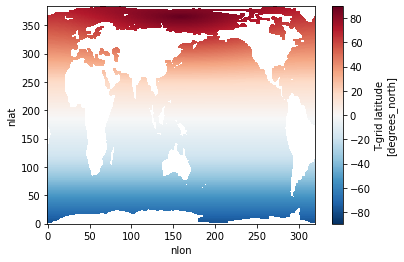

In [5]:
grid.TLAT.where(grid.KMT>0).plot();

The model is a regular lat x lon grid in the southern hemisphere, this we can just use the first column of the `TLAT` array; all other columns are identical.

In [6]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
lat_slice

slice(0, 93, None)

Make a quick-look plot of the regions.

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [7]:
catalog_file = './data/glade-cesm1-le.json'
variables = ['SST', 'diatChl', 'spChl', 'diazChl', 'IFRAC',]# 'Jint_100m_DIC', 
#             'photoC_sp', 'photoC_diat', 'photoC_diaz']

experiments = ['20C', 'RCP85']
stream = 'pop.h'
    
col = intake.open_esm_datastore(catalog_file, sep=',')
col

null:
  args:
    esmcol_obj: ./data/glade-cesm1-le.json
    sep: ','
  description: ''
  driver: intake_esm.core.esm_datastore
  metadata: {}


Now we will search the collection for the ensemble members (unique `member_id`'s) that have a chlorophyll field. This is necessary because the ocean biogeochemistry was corrupted in some members and the data deleted.

In this cell, `member_id` is a list of the ensemble members we want to operate on.

In [8]:
col_sub = col.search(experiment=['20C'],                      
                     stream='pop.h', 
                     variable=['diatChl'])

member_id = list(col_sub.df.member_id.unique())
print(member_id)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 101, 102, 103, 104, 105]


## Now let's search for the data we want

Specify a list of variables and perform a search. Under the hood, the `search` functionality uses [`pandas`](https://pandas.pydata.org/) data frames. We can view that frame here using the `.df` syntax.

In [9]:
col_sub = col.search(
    experiment=experiments, 
    stream=stream, 
    variable=variables,
    member_id=member_id,
    )

print(col_sub)

col_sub.df.head()

<glade-cesm1-le catalog with 2 dataset(s) from 475 asset(s)>


experiment                             case component stream variable  \
0        20C  b.e11.B20TRC5CNBDRD.f09_g16.001       ocn  pop.h    IFRAC   
1        20C  b.e11.B20TRC5CNBDRD.f09_g16.002       ocn  pop.h    IFRAC   
2        20C  b.e11.B20TRC5CNBDRD.f09_g16.009       ocn  pop.h    IFRAC   
3        20C  b.e11.B20TRC5CNBDRD.f09_g16.010       ocn  pop.h    IFRAC   
4        20C  b.e11.B20TRC5CNBDRD.f09_g16.011       ocn  pop.h    IFRAC   

      date_range  member_id  \
0  185001-200512          1   
1  192001-200512          2   
2  192001-200512          9   
3  192001-200512         10   
4  192001-200512         11   

                                                path  ctrl_branch_year  \
0  /glade/campaign/cesm/collections/cesmLE/CESM-C...               402   
1  /glade/campaign/cesm/collections/cesmLE/CESM-C...              1920   
2  /glade/campaign/cesm/collections/cesmLE/CESM-C...              1920   
3  /glade/campaign/cesm/collections/cesmLE/CESM-C...              1920   
4  /glade/campaign/cesm/collections/cesmLE/CESM-C...              1920   

  ctrl_experiment  ctrl_member_id  
0            CTRL               1  
1             20C               1  
2             20C               1  
3             20C               1  
4             20C               1

Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- drop the singleton dimension on SST (which screws up coordinate alignment)
- subset to the time-interval 1920-2100

In [10]:
def fix_sst_time_and_subset(ds):
    """Fix some things in the dataset and subset in space"""   
    grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

    if 'SST' in ds:
        ds['SST'] = ds.SST.isel(z_t=0, drop=True)
             
    data_vars = list(filter(lambda v: v in variables, ds.data_vars))
    
    ds = ds[data_vars+grid_vars].isel(nlat=lat_slice)
    
    # set grid variables to coordinates to ease concatenation in intake-esm
    new_coords = set(grid_vars) - set(ds.coords)

    return ds.set_coords(new_coords)

In [11]:
%%time
dsets = col_sub.to_dataset_dict(cdf_kwargs={'chunks': {'time': 60}, 'decode_times': False},
                                preprocess=fix_sst_time_and_subset)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component,experiment,stream'


CPU times: user 38.8 s, sys: 4.23 s, total: 43 s
Wall time: 1min 52s


{'ocn,20C,pop.h': <xarray.Dataset>
 Dimensions:     (d2: 2, member_id: 34, nlat: 93, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
 Coordinates:
   * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
     ULONG       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     ULAT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     TLAT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
     TAREA       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
     TLONG       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     KMT         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
   * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
   * time        (tim

Now, let's compute the total surface chlorophyll, put time at the mid-point of the interval, and subset to 1920-2100.

In [12]:
def compute_chl_surf(ds):
    """compute surface chl"""

    ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
    ds.Chl_surf.attrs = ds.diatChl.attrs
    ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

    return ds.drop(['diatChl', 'spChl', 'diazChl'])

def compute_NPP_zint(ds):
    """compute surface chl"""
    
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['NPP'] = ((ds.photoC_diat + ds.photoC_sp + ds.photoC_diaz) * dz150m).sum(dim='z_t_150m')
    ds.NPP.attrs = ds.photoC_diat.attrs
    ds.NPP.attrs['long_name'] = 'NPP'
    ds.NPP.attrs['units'] = ds.NPP.attrs['units'] + ' cm'
    
    return ds.drop(['photoC_diat', 'photoC_sp', 'photoC_diaz'])


def fix_time(ds):
    ds = ds.copy(deep=True)
    
    time_attrs = ds.time.attrs
    time_encoding = ds.time.encoding
    
    ds['time'] = xr.DataArray(
        cftime.num2date(
            ds.time_bound.mean(dim='d2'), 
            units=ds.time.units, 
            calendar=ds.time.calendar
        ), 
        dims=('time')
    )
    
    time_encoding['units'] = time_attrs.pop('units')
    time_encoding['calendar'] = time_attrs.pop('calendar')
    
    ds.time.attrs = time_attrs
    ds.time.encoding = time_encoding
    return ds    

In [13]:
# fix time
dsets2 = {key: fix_time(ds) for key, ds in dsets.items()}

# subset time
dsets2 = {key: ds.sel(time=slice('1920', '2100')) for key, ds in dsets2.items()}

# compute surface chl
dsets2 = {key: compute_chl_surf(ds) for key, ds in dsets2.items()}

# compute NPP
#dsets2 = {key: compute_NPP_zint(ds) for key, ds in dsets2.items()}

dsets2

{'ocn,20C,pop.h': <xarray.Dataset>
 Dimensions:     (d2: 2, member_id: 34, nlat: 93, nlon: 320, time: 1032, z_t: 60, z_t_150m: 15)
 Coordinates:
   * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
     ULONG       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     ULAT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     TLAT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
     TAREA       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
     TLONG       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
     KMT         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
   * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
   * time        (tim

Concatenate the datasets in time, i.e. 20C + RCP8.5 experiments.

In [14]:
ordered_dsets_keys = ['ocn,20C,pop.h', 'ocn,RCP85,pop.h']
ds = xr.concat(
    [dsets2[exp] for exp in ordered_dsets_keys], 
    dim='time', 
    data_vars='minimal'
)
time_encoding = dsets2[ordered_dsets_keys[0]].time.encoding
ds

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 34, nlat: 93, nlon: 320, time: 2172, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    dz          (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * member_id   (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
    time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
  * time        (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    IFRAC       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    SST         (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    Chl_surf    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
Attributes:
    tavg_sum:                  2592000.0
    intake_esm_varname:        spChl
    contents:                  Diagnostic and Prognostic Variables
    cell_methods:              cell_methods = time: mean ==> the variable val...
    tavg_sum_qflux:            2592000.0
    nsteps_total:              750
    nco_openmp_thread_number:  1
    NCO:                       4.4.4
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    history:                   Sat Aug 31 15:25:08 2013: /glade/apps/opt/nco/...
    intake_esm_dataset_key:    ocn,20C,pop.h

## Apply bias correction

In [15]:
name_chl_obs = 'SeaWiFS'
ds_obs_chl = xr.open_zarr(f'{util.project_tmpdir}/seawifs_mapped_monthly_chl_gsm_1997-2010.POP_gx1v6.zarr')
ds_obs_chl = ds_obs_chl.isel(nlat=lat_slice).compute()
ds_obs_chl

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 93, nlon: 320, time: 156)
Coordinates:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
  * time         (time) datetime64[ns] 1997-09-25 ... 2010-12-06
    time_bounds  (time, d2) datetime64[ns] 1997-09-18 1997-10-02 ... 2010-12-12
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 ... 35 44 49 52 53 53 53 54
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    chl_gsm      (time, nlat, nlon) float64 nan nan nan ... nan 0.09569 0.09768
    time_bnds    (time, d2) float64 1.012e+04 1.014e+04 ... 1.494e+04 1.496e+04

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'chl_gsm' (month: 12, nlat: 93, nlon: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.13918976, 0.14894726, 0.14233901, ...,        nan,
                nan,        nan],
        ...,
        [0.08858689, 0.08832678, 0.09330244, ..., 0.0909451 ,
         0.08636954, 0.08652949],
        [0.08748639, 0.08700388, 0.09932751, ..., 0.08633381,
         0.08436066, 0.08474976],
        [0.08328618, 0.08480466, 0.08819146, ..., 0.08473444,
         0.08293668, 0.08195453]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.20838466, 0.10204216, 0.27976414, ...,        nan,
                nan,        nan],
        ...,
        [0.0885465 , 0.08423259, 0.08892619, ..., 0.08598373,
         0.08715824, 0.08831622],
        [0.08668498, 0.08546084, 0.08576944, ..., 0.08414013,
         0.08475523, 0.08642996],
        [0.08562632, 0.08623752, 0.08519138, ..., 0.08451298,
         0.08350282, 0.0852483 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.09153554, 0.09247955, 0.08978934, ..., 0.08912301,
         0.09147635, 0.09173709],
        [0.0921602 , 0.08972865, 0.09015915, ..., 0.08796001,
         0.08752266, 0.09092496],
        [0.09121501, 0.08939164, 0.0909227 , ..., 0.08512466,
         0.08637012, 0.09039335]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.11010424, 0.11034292, 0.10371428, ..., 0.12313116,
         0.11988035, 0.11154252],
        [0.10161916, 0.10376826, 0.10096624, ..., 0.12230408,
         0.11384475, 0.1081958 ],
        [0.10240396, 0.10080312, 0.09897519, ..., 0.11729022,
         0.10817503, 0.11121254]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.09567194, 0.09070526, 0.08911145, ..., 0.09982711,
         0.0957802 , 0.09649338],
        [0.09260698, 0.09297538, 0.09181037, ..., 0.09918478,
         0.0938947 , 0.09368633],
        [0.09257977, 0.09084904, 0.08971925, ..., 0.09805856,
         0.09323836, 0.09472152]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.09137952, 0.10680383, 0.09281351, ...,        nan,
                nan,        nan],
        ...,
        [0.09365629, 0.09307494, 0.09216752, ..., 0.09143593,
         0.08958397, 0.09087021],
        [0.09246898, 0.091907  , 0.09002252, ..., 0.09049517,
         0.08860875, 0.09015629],
        [0.08902185, 0.08968957, 0.0878452 , ..., 0.08962715,
         0.08955597, 0.08971251]]])
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


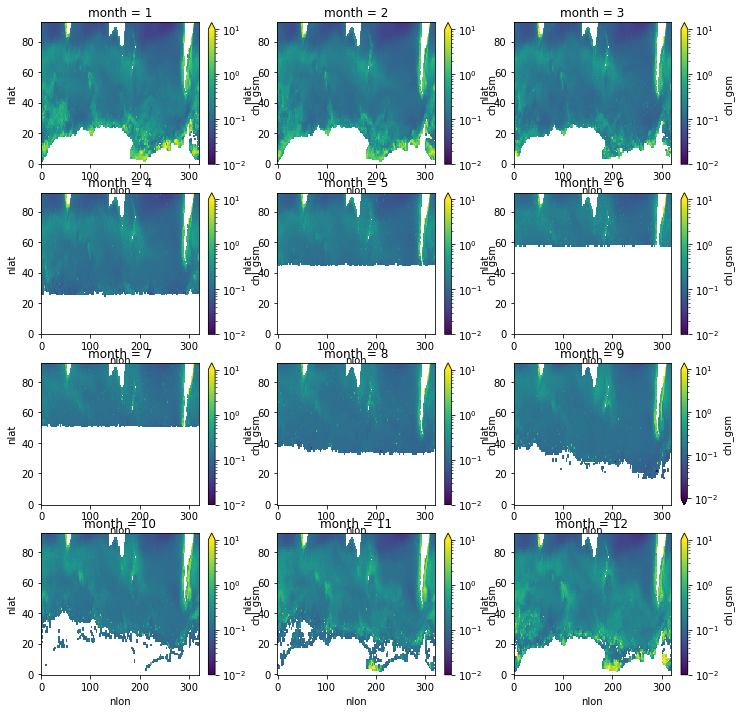

In [16]:
chl_obs_mean = ds_obs_chl.chl_gsm.groupby('time.month').mean('time')
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow))   
for i in range(12):
    ax = axs[np.unravel_index(i, axs.shape)]
    chl_obs_mean.isel(month=i).plot(ax=ax, norm=colors.LogNorm(vmin=0.01, vmax=10,))
chl_obs_mean

In [17]:
chl_mod = ds.Chl_surf.sel(time=slice('1997', '2010'))
chl_mod = chl_mod.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])
chl_mod_mean = chl_mod.groupby('time.month').mean(['time', 'member_id']).compute()
chl_mod_mean

<xarray.DataArray 'Chl_surf' (month: 12, nlat: 93, nlon: 320)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.72022235e+00, 1.71571934e+00, 1.68554664e+00, ...,
                    nan,            nan,            nan],
        ...,
        [9.67552066e-02, 9.46076885e-02, 9.25291926e-02, ...,
         1.01931401e-01, 1.00503996e-01, 9.87340882e-02],
        [9.75527540e-02, 9.51731652e-02, 9.27070677e-02, ...,
         1.02679141e-01, 1.01379998e-01, 9.96285304e-02],
        [9.79476944e-02, 9.52945426e-02, 9.24664959e-02, ...,
         1.03112198e-01, 1.01939976e-01, 1.00194141e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [5.10933101e-01, 5.06111085e-01, 4.96708363e-01, ...,
                    nan,            nan,            nan],
        ...,
        [1.00431018e-01, 9.80084538e-02, 9.54183564e-02, ...,
         1.04294457e-01, 1.03728078e-01, 1.02403745e-01],
        [1.00669719e-01, 9.81509611e-02, 9.53985676e-02, ...,
         1.04336239e-01, 1.03905454e-01, 1.02654666e-01],
        [1.00589827e-01, 9.79729146e-02, 9.49904248e-02, ...,
         1.04179561e-01, 1.03810117e-01, 1.02604687e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.68314949e-01, 1.68291301e-01, 1.68130279e-01, ...,
                    nan,            nan,            nan],
        ...,
        [1.01578198e-01, 1.00556009e-01, 9.95436758e-02, ...,
         1.05464824e-01, 1.04074553e-01, 1.02735028e-01],
        [1.01392969e-01, 1.00392886e-01, 9.93012786e-02, ...,
         1.05159357e-01, 1.03776745e-01, 1.02458231e-01],
        [1.01015791e-01, 1.00032248e-01, 9.88842621e-02, ...,
         1.04716703e-01, 1.03285760e-01, 1.01978078e-01]],

       ...,

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [4.81663179e-03, 4.98959469e-03, 5.16142370e-03, ...,
                    nan,            nan,            nan],
        ...,
        [1.88991159e-01, 1.84441417e-01, 1.80576608e-01, ...,
         2.06130654e-01, 1.99575022e-01, 1.94017500e-01],
        [1.83815077e-01, 1.78666368e-01, 1.74390987e-01, ...,
         2.01794669e-01, 1.95064425e-01, 1.89301267e-01],
        [1.78711563e-01, 1.73189238e-01, 1.68606907e-01, ...,
         1.97847933e-01, 1.90986395e-01, 1.84779242e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [3.78983527e-01, 3.80506963e-01, 3.83463651e-01, ...,
                    nan,            nan,            nan],
        ...,
        [1.23177066e-01, 1.18881144e-01, 1.15332514e-01, ...,
         1.39569774e-01, 1.33308157e-01, 1.27976537e-01],
        [1.19626708e-01, 1.15150146e-01, 1.11445419e-01, ...,
         1.35812700e-01, 1.29756019e-01, 1.24471255e-01],
        [1.16371974e-01, 1.11794151e-01, 1.07857205e-01, ...,
         1.32107198e-01, 1.26432672e-01, 1.21246204e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


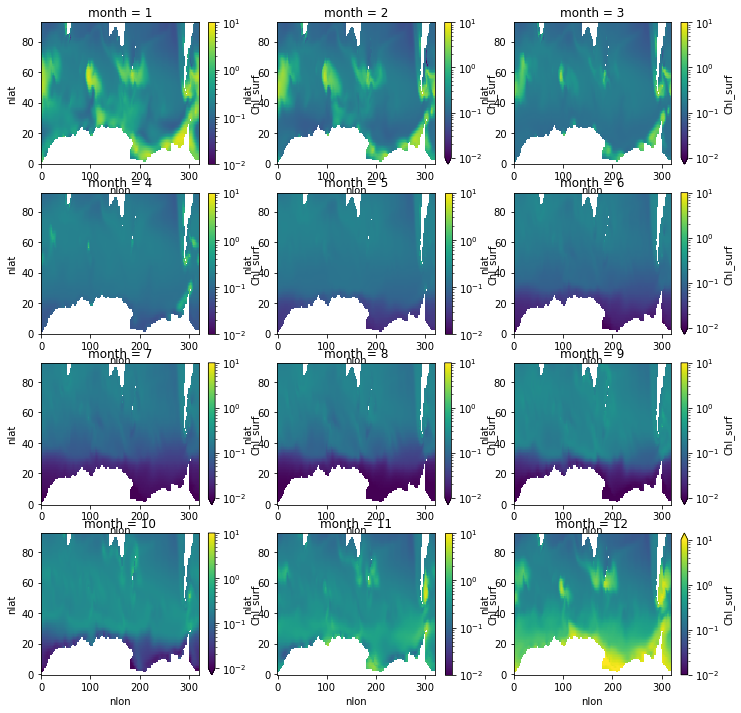

In [18]:
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow))   
for i in range(12):
    ax = axs[np.unravel_index(i, axs.shape)]
    chl_mod_mean.isel(month=i).plot(ax=ax, norm=colors.LogNorm(vmin=0.01, vmax=10,), cmap='viridis')

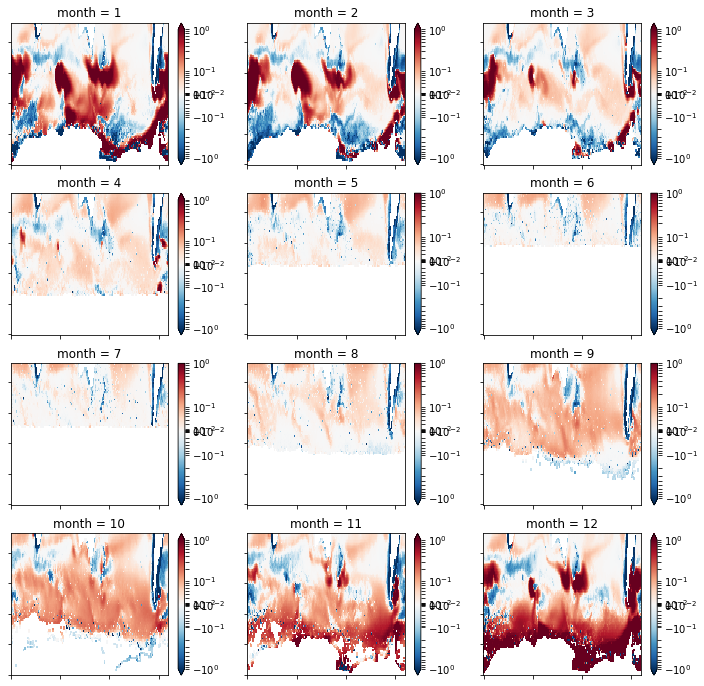

In [19]:
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow))   
for i in range(12):
    ax = axs[np.unravel_index(i, axs.shape)]
    (chl_mod_mean.isel(month=i) - chl_obs_mean.isel(month=i)).plot(
        ax=ax, 
        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                               vmin=-1.0, vmax=1.0, base=10),
        cmap='RdBu_r')
    ax.set_yticklabels([])
    ax.set_xticklabels([])    
    ax.set_ylabel('')
    ax.set_xlabel('')    

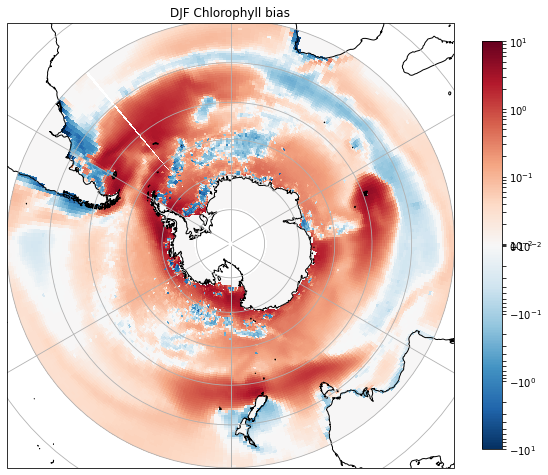

In [20]:
lon, lat = ds.TLONG, ds.TLAT

wgts = xr.DataArray(np.array([31, 28, 31]) / np.array([31, 28, 31]).sum(), dims=('month'))
field = (
    (chl_mod_mean.isel(month=[0, 1, 11])*wgts).sum('month') - 
    (chl_obs_mean.isel(month=[0, 1, 11])*wgts).sum('month')
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())


cmap = 'RdBu_r'

cf = ax.pcolormesh(lon, lat, field,
                 cmap=cmap,
                 norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                               vmin=-10.0, vmax=10.0, base=10),
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()
plt.colorbar(cf, shrink=0.75);
ax.set_title('DJF Chlorophyll bias');

In [21]:
name_sst_obs = 'HadISST'
ds_obs_sst = xr.open_dataset('/glade/work/mclong/HadISST/HadISST_sst_POP_gx1v6.nc', use_cftime=True)
ds_obs_sst = ds_obs_sst.isel(nlat=lat_slice)
ds_obs_sst = ds_obs_sst.sel(time=slice('1981', '2015')).drop(['TLAT', 'TLONG'])
ds_obs_sst

<xarray.Dataset>
Dimensions:    (nlat: 93, nlon: 320, nv: 2, time: 420)
Coordinates:
  * time       (time) object 1981-01-16 12:00:00 ... 2015-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, nv
Data variables:
    sst        (time, nlat, nlon) float64 ...
    time_bnds  (time, nv) object ...
    KMT        (nlat, nlon) int32 ...
    TAREA      (nlat, nlon) float64 ...

In [22]:
sst_obs_mean = ds_obs_sst.sst.groupby('time.month').mean('time')
sst_obs_mean

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (month: 12, nlat: 93, nlon: 320)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.46314799, -1.41319203, -1.37330588, ...,         nan,
                 nan,         nan],
        ...,
        [22.85199367, 22.74446336, 22.69437722, ..., 23.2906345 ,
         23.177485  , 23.03995407],
        [23.31146394, 23.22374932, 23.19827075, ..., 23.71658033,
         23.61113062, 23.48685027],
        [23.5414548 , 23.46460975, 23.44781049, ..., 23.92967042,
         23.82185031, 23.70172918]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.51799097, -1.41826014, -1.34733437, ...,         nan,
                 nan,         nan],
        ...,
        [24.08121447, 24.05548416, 24.04022904, ..., 24.28404082,
         24.18355235, 24.11882986],
        [24.53432321, 24.52159037, 24.52776774, ..., 24.73801213,
         24.64677976, 24.58208802],
        [24.77102894, 24.75963439, 24.76095852, ..., 24.93789077,
         24.86028036, 24.80825378]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.56960299, -1.56487741, -1.55942286, ...,         nan,
                 nan,         nan],
        ...,
        [23.79744522, 23.73369346, 23.69777831, ..., 23.96172515,
         23.91252225, 23.87500079],
        [24.32268702, 24.27522214, 24.25972654, ..., 24.47070286,
         24.44214418, 24.41323322],
        [24.56811776, 24.52359536, 24.50370848, ..., 24.70734478,
         24.67917057, 24.65136722]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.68407732, -1.71328698, -1.7321511 , ...,         nan,
                 nan,         nan],
        ...,
        [18.43598222, 18.33589889, 18.26710708, ..., 18.7450388 ,
         18.63245109, 18.55393131],
        [19.00305941, 18.90433346, 18.80776451, ..., 19.27299146,
         19.15430411, 19.09072466],
        [19.27970493, 19.18212249, 19.07631398, ..., 19.54612379,
         19.4264088 , 19.36167875]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.68531294, -1.69412101, -1.7154857 , ...,         nan,
                 nan,         nan],
        ...,
        [19.65095851, 19.57317133, 19.53662367, ..., 20.06003324,
         19.93107266, 19.81156941],
        [20.17131023, 20.081156  , 20.0230852 , ..., 20.55700622,
         20.42300839, 20.31753678],
        [20.41688053, 20.32299933, 20.25161788, ..., 20.79484492,
         20.65519619, 20.55287745]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.57213177, -1.55922975, -1.56458227, ...,         nan,
                 nan,         nan],
        ...,
        [21.20943491, 21.16738303, 21.13641804, ..., 21.64981979,
         21.4354118 , 21.29612915],
        [21.70186348, 21.65624056, 21.62507883, ..., 22.08443245,
         21.89450891, 21.78173864],
        [21.92683871, 21.87991099, 21.84848165, ..., 22.29426132,
         22.11486241, 22.00757554]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

In [23]:
sst_obs_std = ds_obs_sst.sst.groupby('time.month').std('time')
sst_obs_std

<xarray.DataArray 'sst' (month: 12, nlat: 93, nlon: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.5093692 , 0.50196821, 0.52710086, ...,        nan,
                nan,        nan],
        ...,
        [0.53061377, 0.53544576, 0.52509056, ..., 0.45287703,
         0.46549237, 0.50393727],
        [0.5313683 , 0.51552965, 0.51209914, ..., 0.45846883,
         0.50328078, 0.54099003],
        [0.52960449, 0.51362502, 0.51116117, ..., 0.46082364,
         0.5062963 , 0.54102199]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.40556298, 0.48050973, 0.53877049, ...,        nan,
                nan,        nan],
        ...,
        [0.63947979, 0.65071397, 0.66107774, ..., 0.59294528,
         0.60264392, 0.62150964],
        [0.64286372, 0.64783977, 0.64561282, ..., 0.61243907,
         0.60617533, 0.62214619],
        [0.62828821, 0.63475817, 0.63507634, ..., 0.60397758,
         0.59744849, 0.60961595]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.35322322, 0.35504614, 0.37587852, ...,        nan,
                nan,        nan],
        ...,
        [0.53132629, 0.5362231 , 0.53423001, ..., 0.45497647,
         0.47433719, 0.50642295],
        [0.53401223, 0.538316  , 0.5339411 , ..., 0.47645131,
         0.48129457, 0.50321553],
        [0.52663565, 0.53150916, 0.52771374, ..., 0.47768808,
         0.47905638, 0.49742104]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.20832095, 0.17641748, 0.14931071, ...,        nan,
                nan,        nan],
        ...,
        [0.37276589, 0.35976849, 0.35603732, ..., 0.38662231,
         0.38503306, 0.38398787],
        [0.39134007, 0.38077423, 0.38056169, ..., 0.40944806,
         0.40240603, 0.39827845],
        [0.39032105, 0.38211882, 0.38267726, ..., 0.40539326,
         0.39926187, 0.3949843 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.22065726, 0.21571698, 0.17619111, ...,        nan,
                nan,        nan],
        ...,
        [0.45350483, 0.44580114, 0.44358285, ..., 0.41750383,
         0.44406382, 0.45983065],
        [0.46757224, 0.45384744, 0.45479779, ..., 0.46169048,
         0.47148575, 0.47643468],
        [0.4709586 , 0.45720222, 0.460021  , ..., 0.47452757,
         0.48278649, 0.48419268]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.31252181, 0.34828954, 0.35287504, ...,        nan,
                nan,        nan],
        ...,
        [0.44302844, 0.42298208, 0.41153003, ..., 0.43140429,
         0.46341504, 0.47304172],
        [0.45589469, 0.43104195, 0.4098359 , ..., 0.4576431 ,
         0.47103047, 0.47310924],
        [0.4564614 , 0.43080842, 0.40840969, ..., 0.46444035,
         0.47227133, 0.47155467]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

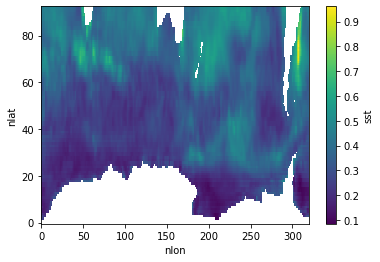

In [24]:
sst_obs_std.mean('month').plot()

In [25]:
sst_mod = ds.SST.sel(time=slice('1981', '2015'))
sst_mod = sst_mod.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])
sst_mod = sst_mod.compute()
sst_mod

<xarray.DataArray 'SST' (member_id: 34, time: 420, nlat: 93, nlon: 320)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.6991855e+00, -1.6915283e+00, -1.6864736e+00, ...,
                     nan,            nan,            nan],
         ...,
         [ 2.2579020e+01,  2.2539007e+01,  2.2513855e+01, ...,
           2.2820360e+01,  2.2740726e+01,  2.2650576e+01],
         [ 2.2731470e+01,  2.2711626e+01,  2.2706684e+01, ...,
           2.2933929e+01,  2.2857376e+01,  2.2781525e+01],
         [ 2.2902317e+01,  2.2914652e+01,  2.2925940e+01, ...,
           2.3067505e+01,  2.2981457e+01,  2.2918276e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.7616354e+00, -1.7573241e+00, -1.7498465e+00, ...,
                     nan,            nan,            nan],
         ...,
         [ 2.3979248e+01,  2.3980045e+01,  2.4024477e+01, ...,
           2.4176693e+01,  2.4089806e+01,  2.4027107e+01],
         [ 2.4144199e+01,  2.4184088e+01,  2.4256992e+01, ...,
           2.4301044e+01,  2.4214985e+01,  2.4161312e+01],
         [ 2.4325247e+01,  2.4392517e+01,  2.4484808e+01, ...,
           2.4435032e+01,  2.4340509e+01,  2.4305159e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.8085482e+00, -1.8114290e+00, -1.8070745e+00, ...,
                     nan,            nan,            nan],
         ...,
         [ 2.4587284e+01,  2.4715401e+01,  2.4840275e+01, ...,
           2.4394005e+01,  2.4407089e+01,  2.4480562e+01],
         [ 2.4860487e+01,  2.5003475e+01,  2.5128531e+01, ...,
           2.4568974e+01,  2.4614283e+01,  2.4726879e+01],
         [ 2.5100693e+01,  2.5237230e+01,  2.5356592e+01, ...,
           2.4759466e+01,  2.4828556e+01,  2.4964081e+01]],

        ...,

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.8347864e+00, -1.8339579e+00, -1.8324053e+00, ...,
                     nan,            nan,            nan],
         ...,
         [ 1.9167997e+01,  1.9201431e+01,  1.9195244e+01, ...,
           1.9189465e+01,  1.9168262e+01,  1.9154593e+01],
         [ 1.9568840e+01,  1.9622154e+01,  1.9627714e+01, ...,
           1.9583397e+01,  1.9559166e+01,  1.9551659e+01],
         [ 1.9977421e+01,  2.0014833e+01,  2.0013731e+01, ...,
           1.9975252e+01,  1.9953926e+01,  1.9957195e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.8034236e+00, -1.7975777e+00, -1.7931188e+00, ...,
                     nan,            nan,            nan],
         ...,
         [ 2.0218750e+01,  2.0202417e+01,  2.0148291e+01, ...,
           2.0377529e+01,  2.0298853e+01,  2.0248564e+01],
         [ 2.0607998e+01,  2.0588015e+01,  2.0531889e+01, ...,
           2.0777451e+01,  2.0697001e+01,  2.0645123e+01],
         [ 2.1005739e+01,  2.0969702e+01,  2.0897755e+01, ...,
           2.1173887e+01,  2.1100811e+01,  2.1052832e+01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,          

In [26]:
sst_mod_mean = sst_mod.groupby('time.month').mean(['time', 'member_id'])
sst_mod_mean = sst_mod_mean.compute()
sst_mod_mean

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'SST' (month: 12, nlat: 93, nlon: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.2423656, -1.1951313, -1.1479349, ...,        nan,
                nan,        nan],
        ...,
        [22.999285 , 22.975283 , 22.956896 , ..., 23.08573  ,
         23.045279 , 23.021078 ],
        [23.289316 , 23.261263 , 23.243774 , ..., 23.372065 ,
         23.335062 , 23.310936 ],
        [23.56964  , 23.544125 , 23.527428 , ..., 23.65632  ,
         23.617643 , 23.589943 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.4085689, -1.3803637, -1.3522793, ...,        nan,
                nan,        nan],
        ...,
        [24.176514 , 24.170088 , 24.16261  , ..., 24.251268 ,
         24.217756 , 24.196365 ],
        [24.441202 , 24.4368   , 24.43273  , ..., 24.507856 ,
         24.475039 , 24.456932 ],
        [24.692694 , 24.689283 , 24.692038 , ..., 24.754377 ,
         24.723602 , 24.703661 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.8038373, -1.8053198, -1.7956959, ...,        nan,
                nan,        nan],
        ...,
        [24.136782 , 24.128542 , 24.115229 , ..., 24.218388 ,
         24.177582 , 24.152828 ],
        [24.420835 , 24.413868 , 24.402443 , ..., 24.489449 ,
         24.454508 , 24.4355   ],
        [24.697893 , 24.689945 , 24.678051 , ..., 24.750383 ,
         24.727186 , 24.715494 ]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.8259056, -1.8254832, -1.8229061, ...,        nan,
                nan,        nan],
        ...,
        [18.479042 , 18.469381 , 18.435883 , ..., 18.674444 ,
         18.578    , 18.50999  ],
        [18.847145 , 18.836983 , 18.805027 , ..., 19.038311 ,
         18.948359 , 18.882597 ],
        [19.216738 , 19.195827 , 19.162561 , ..., 19.398777 ,
         19.318624 , 19.25698  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.7826872, -1.7769991, -1.7717353, ...,        nan,
                nan,        nan],
        ...,
        [19.513313 , 19.497751 , 19.466743 , ..., 19.658028 ,
         19.579107 , 19.534382 ],
        [19.867508 , 19.851698 , 19.820335 , ..., 20.009983 ,
         19.93605  , 19.8937   ],
        [20.218721 , 20.19883  , 20.165163 , ..., 20.363287 ,
         20.29414  , 20.251833 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-1.5676744, -1.53338  , -1.4997615, ...,        nan,
                nan,        nan],
        ...,
        [21.163898 , 21.139387 , 21.117867 , ..., 21.262794 ,
         21.210913 , 21.186323 ],
        [21.496222 , 21.467833 , 21.447107 , ..., 21.5949   ,
         21.545702 , 21.519411 ],
        [21.822273 , 21.794737 , 21.771034 , ..., 21.926481 ,
         21.87826  , 21.849337 ]]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

In [27]:
sst_mod_std = sst_mod.groupby('time.month').std(['time', 'member_id'])
sst_mod_std = sst_mod_std.compute()
sst_mod_std

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'SST' (month: 12, nlat: 93, nlon: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.9149179 , 0.93838227, 0.95972985, ...,        nan,
                nan,        nan],
        ...,
        [0.59198093, 0.59456676, 0.5971362 , ..., 0.5909192 ,
         0.5894169 , 0.5900093 ],
        [0.57754326, 0.5806323 , 0.583275  , ..., 0.5754558 ,
         0.5738005 , 0.5746831 ],
        [0.56004924, 0.56325257, 0.56562257, ..., 0.5575081 ,
         0.5554679 , 0.55646753]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.73321563, 0.75190777, 0.76741606, ...,        nan,
                nan,        nan],
        ...,
        [0.58968276, 0.5959284 , 0.59923035, ..., 0.56603205,
         0.57321876, 0.58197546],
        [0.575182  , 0.582259  , 0.5859303 , ..., 0.5495814 ,
         0.5568735 , 0.56625086],
        [0.5568108 , 0.5644515 , 0.56880957, ..., 0.5304948 ,
         0.53736436, 0.54692966]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.08625343, 0.09433017, 0.1001902 , ...,        nan,
                nan,        nan],
        ...,
        [0.59965235, 0.60217834, 0.60460955, ..., 0.5740934 ,
         0.5857561 , 0.5948208 ],
        [0.5911982 , 0.59399235, 0.5963888 , ..., 0.56433743,
         0.57666504, 0.58591264],
        [0.5801448 , 0.5832641 , 0.5854208 , ..., 0.55178434,
         0.5642526 , 0.574081  ]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.01132597, 0.01155645, 0.01086736, ...,        nan,
                nan,        nan],
        ...,
        [0.53760463, 0.5376649 , 0.5380385 , ..., 0.52407104,
         0.5313746 , 0.53642946],
        [0.53854156, 0.5392174 , 0.53915197, ..., 0.5280648 ,
         0.5338835 , 0.5375538 ],
        [0.5373908 , 0.53804076, 0.5376371 , ..., 0.52950245,
         0.53318375, 0.5359113 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.02055608, 0.02475037, 0.02788264, ...,        nan,
                nan,        nan],
        ...,
        [0.57486236, 0.57268316, 0.56956506, ..., 0.5621278 ,
         0.5681681 , 0.57345814],
        [0.5757505 , 0.57311714, 0.5695422 , ..., 0.56573087,
         0.5705985 , 0.57490623],
        [0.5738446 , 0.5710667 , 0.5670248 , ..., 0.5682086 ,
         0.57124746, 0.57372016]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.31700993, 0.34926757, 0.3724181 , ...,        nan,
                nan,        nan],
        ...,
        [0.6136602 , 0.6109693 , 0.60920763, ..., 0.6143061 ,
         0.6143553 , 0.6151617 ],
        [0.6050206 , 0.6016811 , 0.5995726 , ..., 0.6093437 ,
         0.60807294, 0.60724396],
        [0.59405977, 0.5903334 , 0.58690727, ..., 0.60202533,
         0.59905505, 0.59662175]]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

In [28]:
da = ds.SST.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])

zscore = ((da.groupby('time.month') - sst_mod_mean)
          .groupby('time.month') / sst_mod_std)

sst_bias_corr = ((zscore.groupby('time.month') * sst_obs_std)
                 .groupby('time.month') + sst_obs_mean)

sst_bias_corr

<xarray.DataArray (member_id: 34, time: 2172, nlat: 93, nlon: 320)>
dask.array<getitem, shape=(34, 2172, 93, 320), dtype=float64, chunksize=(1, 1, 93, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

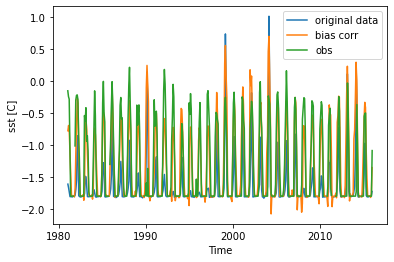

In [29]:
nlat = 20
nlon = 50
ds.SST.sel(time=slice('1981', '2015')).isel(member_id=0, nlat=nlat, nlon=nlon).plot(label='original data')
sst_bias_corr.sel(time=slice('1981', '2015')).isel(member_id=0, nlat=nlat, nlon=nlon).plot(label='bias corr')
ds_obs_sst.sst.isel(nlat=nlat, nlon=nlon).plot(label='obs')
plt.legend();

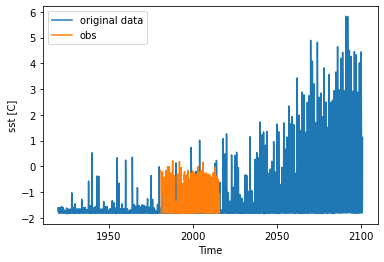

In [30]:
ds.SST.isel(member_id=0, nlat=nlat, nlon=nlon).plot(label='original data')
#sst_bias_corr.isel(member_id=0, nlat=nlat, nlon=nlon).plot(label='bias corr')
ds_obs_sst.sst.isel(nlat=nlat, nlon=nlon).plot(label='obs')
plt.legend();

In [31]:
ds = ds.rename(SST='SST_orig')
ds['SST'] = sst_bias_corr
ds.SST.attrs = ds.SST_orig.attrs
ds.SST.attrs['note'] = f'bias corrected using {name_sst_obs}; reference period 1981-2015'
ds

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 34, nlat: 93, nlon: 320, time: 2172, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    dz          (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * member_id   (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
    time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
  * time        (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    IFRAC       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    SST_orig    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    Chl_surf    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    SST         (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
Attributes:
    tavg_sum:                  2592000.0
    intake_esm_varname:        spChl
    contents:                  Diagnostic and Prognostic Variables
    cell_methods:              cell_methods = time: mean ==> the variable val...
    tavg_sum_qflux:            2592000.0
    nsteps_total:              750
    nco_openmp_thread_number:  1
    NCO:                       4.4.4
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    history:                   Sat Aug 31 15:25:08 2013: /glade/apps/opt/nco/...
    intake_esm_dataset_key:    ocn,20C,pop.h

## Compute Krill Growth Potential

Define a "length" coordinate.

In [32]:
length = xr.DataArray(
    [20., 40., 60.], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
length

<xarray.DataArray 'length' (length: 3)>
array([20., 40., 60.])
Dimensions without coordinates: length
Attributes:
    units:      mm
    long_name:  Krill body length

Perform the actual computation

In [33]:
ds = util.compute_kgp(ds, length)
ds

<xarray.Dataset>
Dimensions:     (d2: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, time: 2172, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    dz          (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * member_id   (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
    time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
  * time        (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * length      (length) float64 20.0 40.0 60.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    IFRAC       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    SST_orig    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    Chl_surf    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    SST         (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    KGP         (length, member_id, time, nlat, nlon) float64 dask.array<chunksize=(3, 1, 1, 93, 320), meta=np.ndarray>
Attributes:
    tavg_sum:                  2592000.0
    intake_esm_varname:        spChl
    contents:                  Diagnostic and Prognostic Variables
    cell_methods:              cell_methods = time: mean ==> the variable val...
    tavg_sum_qflux:            2592000.0
    nsteps_total:              750
    nco_openmp_thread_number:  1
    NCO:                       4.4.4
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    history:                   Sat Aug 31 15:25:08 2013: /glade/apps/opt/nco/...
    intake_esm_dataset_key:    ocn,20C,pop.h

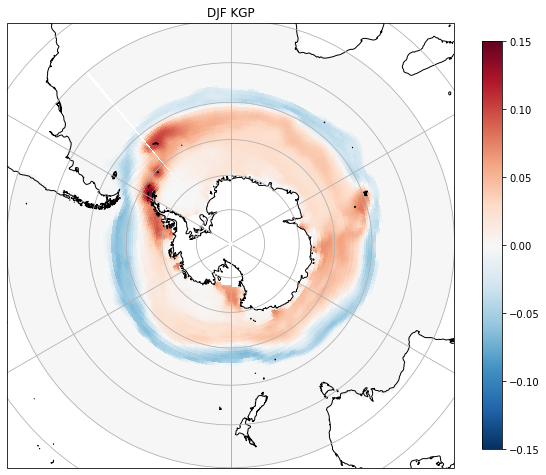

In [35]:
lon, lat = ds.TLONG, ds.TLAT
field = ds.KGP.sel(time=slice('1920', '1950'), length=40.).isel(member_id=0).mean('time')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())


cmap = 'RdBu_r'

cf = ax.pcolormesh(lon, lat, field,
                   cmap=cmap,
                   vmin=-0.15, vmax=0.15,
                   transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()
plt.colorbar(cf, shrink=0.75);
ax.set_title('DJF KGP');

In [36]:
sst_range = (0.5 <= ds.SST.isel(member_id=0)) & (ds.SST.isel(member_id=0) <= 1.5)

x = ds.Chl_surf.isel(member_id=0, time=slice(0, 36)).where(sst_range).values.ravel()
y = ds.KGP.isel(member_id=0, time=slice(0, 36)).sel(length=40).where(sst_range).values.ravel()

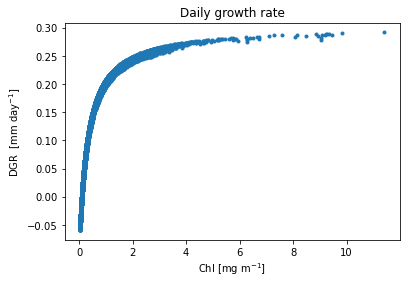

In [37]:
plt.plot(x, y, '.')
plt.title('Daily growth rate');
plt.xlabel('Chl [mg m$^{-1}$]');
plt.ylabel('DGR  [mm day$^{-1}$]');

## Compute summer time (DJF) means 

In [38]:
%%time
ds_djf = util.ann_mean(ds, season='DJF', time_bnds_varname='time_bound', time_centered=True)
ds_djf

CPU times: user 13 s, sys: 340 ms, total: 13.4 s
Wall time: 14.6 s


<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    dz         (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * z_t        (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * length     (length) float64 20.0 40.0 60.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    IFRAC      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    SST_orig   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 3, 1, 93, 320), meta=np.ndarray>

In [39]:
%%time
ds_ann = util.ann_mean(ds, time_bnds_varname='time_bound', time_centered=True)
ds_ann

CPU times: user 11.8 s, sys: 212 ms, total: 12 s
Wall time: 11.9 s


<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 181, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    dz         (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * z_t        (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * length     (length) float64 20.0 40.0 60.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    IFRAC      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    SST_orig   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 3, 1, 93, 320), meta=np.ndarray>

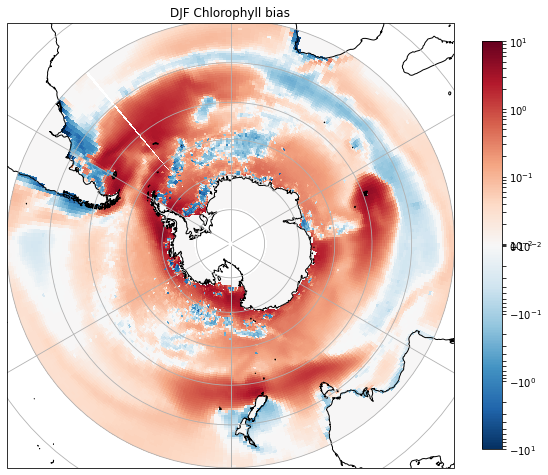

In [40]:
lon, lat = ds.TLONG, ds.TLAT

chl_mod = ds.Chl_surf.sel(time=slice('1997', '2010'))
chl_mod = chl_mod.drop(['TLONG', 'TLAT', 'KMT', 'ULAT', 'ULONG', 'TAREA'])
chl_mod_mean = chl_mod.groupby('time.month').mean(['time', 'member_id']).compute()

wgts = xr.DataArray(np.array([31, 28, 31]) / np.array([31, 28, 31]).sum(), dims=('month'))
field = (
    (chl_mod_mean.isel(month=[0, 1, 11])*wgts).sum('month') - 
    (chl_obs_mean.isel(month=[0, 1, 11])*wgts).sum('month')
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())


cmap = 'RdBu_r'

cf = ax.pcolormesh(lon, lat, field,
                 cmap=cmap,
                 norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                               vmin=-10.0, vmax=10.0, base=10),
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()
plt.colorbar(cf, shrink=0.75);
ax.set_title('DJF Chlorophyll bias');

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


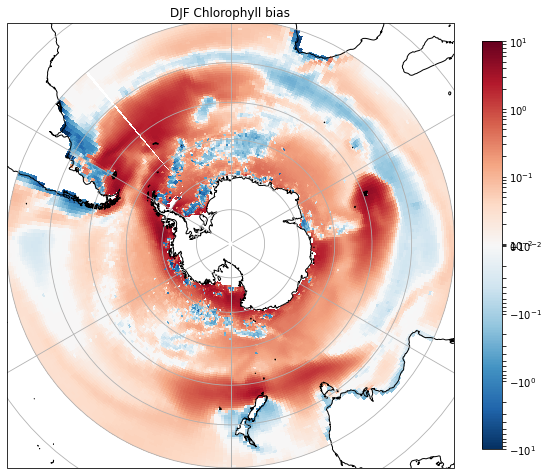

In [41]:
lon, lat = ds.TLONG, ds.TLAT
field = ds_djf.Chl_surf.sel(time=slice('1997', '2010')).mean(['time', 'member_id']) - chl_obs_mean.isel(month=[0, 1, 11]).mean('month')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())


cmap = 'RdBu_r'

cf = ax.pcolormesh(lon, lat, field,
                 cmap=cmap,
                 norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                               vmin=-10.0, vmax=10.0, base=10),
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()
plt.colorbar(cf, shrink=0.75);
ax.set_title('DJF Chlorophyll bias');

In [42]:
%%time
dso_map = {
    f'{util.project_tmpdir}/cesm-le-fields-djf.zarr': ds_djf.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1,
        'length': -1,
    }
    ), 
    f'{util.project_tmpdir}/cesm-le-fields-ann.zarr': ds_ann.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1,
        'length': -1,
    }
    ),     
}
for file_out, dso in dso_map.items():
    util.write_ds_out(dso, file_out)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-fields-djf.zarr
xarray.Dataset {
dimensions:
	length = 3 ;
	member_id = 34 ;
	nlat = 93 ;
	nlon = 320 ;
	time = 180 ;
	z_t = 60 ;
	z_t_150m = 15 ;

variables:
	float64 ULONG(nlat, nlon) ;
		ULONG:long_name = array of u-grid longitudes ;
		ULONG:units = degrees_east ;
	float64 ULAT(nlat, nlon) ;
		ULAT:long_name = array of u-grid latitudes ;
		ULAT:units = degrees_north ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float32 dz(z_t) ;
		dz:long_name = thickness of layer k ;
		dz:units = centimeters ;
	float64 TAREA(nlat, nlon) ;
		TAREA:long_name = area of T cells ;
		TAREA:units = centimeter^2 ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 z_t(z_t) ;
		z_t:long_name = depth from 